<div style="text-align: center; font-family: 'Segoe UI', sans-serif; color: #333; padding: 20px; border-radius: 12px; border: 1px solid #97b83a; background-color: #f9fdf4;">

  <h1 style="color: #97b83a; margin-bottom: 10px;">Computational Intelligence for Optimization <span style="font-weight: 300;">2024–25 | NOVA IMS</span></h1>

  <h3 style="margin-top: 5px; margin-bottom: 20px; font-weight: 500;">Professors: Leonardo Vanneschi | Inês Magessi</h3>

  <h4 style="margin-top: 20px; margin-bottom: 10px; color: #444;"> Music Festival Lineup Optimization</h4>

  <h5 style="margin-top: 20px; margin-bottom: 5px; color: #666;">Group O Members:</h5>
  <ul style="list-style: none; padding-left: 0; line-height: 1.6;">
    <li>Ana Margarida Valente | <a href="mailto:20240936@novaims.unl.pt" style="color: #97b83a;">20240936@novaims.unl.pt</a></li>
    <li>Luana Rocha | <a href="mailto:20240111@novaims.unl.pt" style="color: #97b83a;">20240111@novaims.unl.pt</a></li>
    <li>Pedro Costa | <a href="mailto:20222121@novaims.unl.pt" style="color: #97b83a;">20222121@novaims.unl.pt</a></li>
    <li>Susana Reis | <a href="mailto:20240567@novaims.unl.pt" style="color: #97b83a;">20240567@novaims.unl.pt</a></li>
  </ul>

</div>


### Project Overview: Music Festival Lineup Optimization

The goal of this project is to design an optimal music festival lineup by scheduling artists across 5 stages and 7 time slots. Each artist is characterized by a popularity score, genre, and pairwise fanbase conflict scores with other artists.

To evaluate a lineup, we optimize three equally important and normalized objectives:
- **Prime Slot Popularity**: Maximizing the popularity of artists in final time slots.
- **Genre Diversity**: Ensuring a wide range of musical genres per time slot.
- **Conflict Penalty**: Minimizing scheduling of artists with overlapping fan bases at the same time.

Each solution must comply with strict constraints: all artists must be assigned exactly once, and no lineup should include duplicates or omissions.

The dataset includes artist information and a conflict matrix, and solutions are evolved under these conditions to find high quality festival arrangements.


### 1. Imports

In [52]:
#pip install -r requirements.txt

In [1]:
import sys
import os

# Add the parent directory of 'src' to the path
sys.path.append(os.path.abspath('..'))

In [ ]:
import random
from copy import deepcopy
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import pickle
import seaborn as sns
from collections import Counter
import itertools
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import re
from collections import defaultdict


from lib.Projectsolution import Solution
import importlib
import lib.genetic_algorithm
import lib.crossover
import lib.mutation
import lib.fitness
import lib.selection
import lib.Projectsolution

importlib.reload(lib.genetic_algorithm)
importlib.reload(lib.crossover)
importlib.reload(lib.mutation)
importlib.reload(lib.fitness)
importlib.reload(lib.selection)
importlib.reload(lib.Projectsolution)

from lib.genetic_algorithm import genetic_algorithm
from lib.crossover import pmx_crossover, order_crossover
from lib.mutation import swap_mutation, inversion_mutation, insertion_mutation, prime_slot_mutation, slot_shuffle_mutation
from lib.fitness import fitness
from lib.selection import tournament_selection, ranking_selection
from lib.Projectsolution import Solution



### 2. Load Data

In [4]:
# Load artists data
artists_df = pd.read_csv("../data/artists(in).csv")

# Preview the first few rows
print(artists_df.head())

print(f"\n Number of artists: {len(artists_df)}")

   Unnamed: 0             name       genre  popularity
0           0    Midnight Echo        Rock          75
1           1      Solar Flare  Electronic          78
2           2     Velvet Pulse        Jazz          35
3           3     Neon Reverie  Electronic         100
4           4  The Silver Owls   Classical          85

 Number of artists: 35


In [5]:
# Load conflic matrix
conflict_df = pd.read_csv("../data/conflicts(in).csv", index_col=0)

# Convert to NumPy matrix for easier computation later
conflict_matrix = conflict_df.to_numpy()

# Check matrix size
print("Conflict matrix shape:", conflict_matrix.shape)

Conflict matrix shape: (35, 35)


-------------------------------------

### <b style="background-color:#97b83a; padding:5px; border-radius:5px; display: inline-block;"> EDA & Preprocessing </b>

- **Artists Dataframe**
- **Conflict Matrix**

#### <b style="background-color:#97b83a; padding:5px; border-radius:5px; display: inline-block;">Artists Dataframe</b>

In [6]:
artists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  35 non-null     int64 
 1   name        35 non-null     object
 2   genre       35 non-null     object
 3   popularity  35 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.2+ KB


- Rename the column "Unnamed: 0" to "id"

In [7]:
# Rename the column "Unnamed: 0"
artists_df.rename(columns={"Unnamed: 0": "id"}, inplace=True)

# Confirm the change
print(artists_df.head())

   id             name       genre  popularity
0   0    Midnight Echo        Rock          75
1   1      Solar Flare  Electronic          78
2   2     Velvet Pulse        Jazz          35
3   3     Neon Reverie  Electronic         100
4   4  The Silver Owls   Classical          85


- Convert the categorical 'genre' column into numeric codes and store the corresponding labels.

In [8]:
# Convert the 'genre' column in the DataFrame into numeric codes
# 'genre_code' will contain the numeric representation of each genre
# 'genre_uniques' will contain the list of unique genres in the order they were assigned
artists_df['genre_code'], genre_uniques = pd.factorize(artists_df['genre'])

# Display the first few rows of the original 'genre' column and the new 'genre_code' column
print(artists_df[['genre', 'genre_code']].head())

        genre  genre_code
0        Rock           0
1  Electronic           1
2        Jazz           2
3  Electronic           1
4   Classical           3


In [9]:
genre_uniques

Index(['Rock', 'Electronic', 'Jazz', 'Classical', 'Pop', 'Hip-Hop'], dtype='object')

- Normalize the 'popularity' column to the [0, 1] range using MinMaxScaler

In [10]:
# Normalize the 'popularity' column using MinMaxScaler
popularity = artists_df[['popularity']].values  
scaler = MinMaxScaler()
artists_df['popularity_norm'] = scaler.fit_transform(popularity)
print(artists_df['popularity_norm'].head())


0    0.6875
1    0.7250
2    0.1875
3    1.0000
4    0.8125
Name: popularity_norm, dtype: float64


- Define a class to represent each artist with relevant attributes

In [12]:
# Define a class to represent each artist with relevant attributes
class Artist:
    def __init__(self, id, name, popularity, genre, genre_code, popularity_norm):
        # Initialize artist attributes with provided values
        self.id = id
        self.name = name
        self.popularity = popularity
        self.genre = genre
        self.genre_code = genre_code
        self.popularity_norm = popularity_norm

    def __repr__(self):
        # Define how the artist object will be displayed when printed
        return f"{self.name} (Pop: {self.popularity}, Genre: {self.genre}, NormPop: {self.popularity_norm})"


# Create a list of Artist objects by iterating over each row in the DataFrame
artists = [
    Artist(row["id"], row["name"], row["popularity"], row["genre"], row["genre_code"], row['popularity_norm'])
    for _, row in artists_df.iterrows()
]

In [15]:
artists

[Midnight Echo (Pop: 75, Genre: Rock, NormPop: 0.6875),
 Solar Flare (Pop: 78, Genre: Electronic, NormPop: 0.7250000000000001),
 Velvet Pulse (Pop: 35, Genre: Jazz, NormPop: 0.1875),
 Neon Reverie (Pop: 100, Genre: Electronic, NormPop: 1.0),
 The Silver Owls (Pop: 85, Genre: Classical, NormPop: 0.8125),
 Echo Chamber (Pop: 98, Genre: Electronic, NormPop: 0.9750000000000001),
 Aurora Skies (Pop: 75, Genre: Pop, NormPop: 0.6875),
 Static Mirage (Pop: 94, Genre: Rock, NormPop: 0.925),
 Crimson Harmony (Pop: 20, Genre: Classical, NormPop: 0.0),
 Deep Resonance (Pop: 90, Genre: Jazz, NormPop: 0.875),
 The Wandering Notes (Pop: 84, Genre: Jazz, NormPop: 0.8),
 Phantom Groove (Pop: 47, Genre: Hip-Hop, NormPop: 0.3375),
 Blue Horizon (Pop: 51, Genre: Pop, NormPop: 0.38750000000000007),
 Lunar Spectrum (Pop: 99, Genre: Rock, NormPop: 0.9875),
 Synthwave Saints (Pop: 94, Genre: Rock, NormPop: 0.925),
 Golden Ember (Pop: 61, Genre: Rock, NormPop: 0.5125000000000001),
 Mystic Rhythms (Pop: 78, Gen

#### <b style="background-color:#97b83a; padding:5px; border-radius:5px; display: inline-block;">Conflict Matrix</b>

In [16]:
conflict_matrix[:5, :5]  

array([[0. , 0. , 0. , 0.2, 0.5],
       [0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. , 0.5],
       [0.2, 1. , 1. , 0. , 0.2],
       [0.5, 0. , 0.5, 0.2, 0. ]])

Since the confusion matrix already displays values normalized to the [0,1] range, no further transformation is necessary.

### <b style="background-color:#97b83a; padding:5px; border-radius:5px; display: inline-block;"> Optimization Tests  </b>

In [17]:
# Create a list with all the values from the 'id' column of the DataFrame artists_df
artist_ids = list(artists_df['id'])

# Initialize an empty list to store the fitness values throughout the evolutionary process
fitness_history = []

#### Manual Test

In [ ]:
# Define manual parameters to test
xo = 'pmx'                  # Crossover method: 'pmx' or 'ox'
mut = 'insertion'           # Mutation method: 'insertion', 'prime', 'shuffle'
sel = tournament_selection  # Selection method: tournament_selection or ranking_selection
sel_params = {'k': 3}       # Parameters for selection

xo_prob = 0.9
mut_prob = 0.1

# Initialize the population with the selected configuration
pop = [
    Solution(
        random.sample(artist_ids, len(artist_ids)),
        artists=artists,
        conflict_matrix=conflict_matrix,
        crossover_method=xo,
        mutation_method=mut
    )
    for _ in range(100)
]

# Run the algorithm
best_solution, fitness_over_time = genetic_algorithm(
    initial_population=pop,
    max_gen=100,
    selection_algorithm=(sel, sel_params),  
    maximization=True,
    xo_prob=xo_prob,
    mut_prob=mut_prob,
    elitism=True,
    verbose=True,
    track_history=True
)

# Output results
print("\nFinal fitness:", best_solution.fitness())

# Plot fitness over generations
plt.plot(fitness_over_time)
plt.title(f"Fitness over Generations ({xo}, {mut}, {sel.__name__})")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.grid(True)
plt.show()



#### Genetic Algorithm Parameter Grid Search (With Fixed Probabilities and Fixed Selection Method Parameters)

In [19]:
POP_SIZE = 100
GENERATIONS = 100

# Mapping selection names to functions
selection_methods = {
    "tournament": tournament_selection,
    "ranking": ranking_selection
}

grid_params = {
    "crossover": [
        {"method": "pmx", "xo_prob": 0.8},
        {"method": "ox", "xo_prob": 0.8}
    ],
    "mutation": [
        {"method": "insertion", "mut_prob": 0.2},
        {"method": "prime", "mut_prob": 0.2},
        {"method": "shuffle", "mut_prob": 0.2},
    ],
    "selection": [
        {"method": "tournament"},
        {"method": "ranking"},
    ],
    "elitism": [True, False]
}

fitness_dfs = {}
grid = list(itertools.product(
    grid_params["crossover"],
    grid_params["mutation"],
    grid_params["selection"],
    grid_params["elitism"]
))

for crossover_cfg, mutation_cfg, selection_cfg, elitism in grid:
    df = pd.DataFrame(columns=range(GENERATIONS))  # shape 30x200
    xo_method = crossover_cfg["method"]
    xo_prob = crossover_cfg["xo_prob"]
    mut_method = mutation_cfg["method"]
    mut_prob = mutation_cfg["mut_prob"]
    sel_method_name = selection_cfg["method"]
    sel_function = selection_methods[sel_method_name]

    for run_nr in range(30):
        initial_population = [
            Solution(
                representation=random.sample(artist_ids, len(artist_ids)),
                artists=artists,
                conflict_matrix=conflict_matrix,
                crossover_method=xo_method,
                mutation_method=mut_method
            ) for _ in range(POP_SIZE)
        ]

        best_solution, fitness_over_gens = genetic_algorithm(
            initial_population=initial_population,
            max_gen=GENERATIONS,
            selection_algorithm=sel_function,
            xo_prob=xo_prob,
            mut_prob=mut_prob,
            elitism=elitism,
            maximization=True,
            verbose=False,
            track_history=True
        )

        df.loc[run_nr] = fitness_over_gens

    label = f"{xo_method}{xo_prob}_{mut_method}{mut_prob}_{sel_method_name}_elitism={elitism}"
    fitness_dfs[label] = df


#### Isolating the Impact of Elitism

In [ ]:
def plot_fitness_by_elitism(fitness_dfs: dict[str, pd.DataFrame]):
    """
    Plot mean and median fitness across generations,
    separated by elitism = True or False.
    
    Assumes keys contain '_elitism=True' or '_elitism=False'.
    """
    
    # Group by elitism flag
    grouped = defaultdict(dict)
    for config_name, df in fitness_dfs.items():
        # Extract elitism flag from key
        match = re.search(r"_elitism=(True|False)", config_name)
        elitism_flag = match.group(1) if match else "unknown"
        grouped[elitism_flag][config_name] = df

    for elitism_flag, configs in grouped.items():
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
        handles, labels = [], []

        for config_name, df in configs.items():
            mean_fitness = df.mean(axis=0)
            median_fitness = df.median(axis=0)

            line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name)
            axes[1].plot(median_fitness.index, median_fitness.values, label=config_name)

            handles.append(line1)
            labels.append(config_name)

        axes[0].set_title(f"Mean Fitness Across Generations - Elitism = {elitism_flag}")
        axes[1].set_title(f"Median Fitness Across Generations - Elitism = {elitism_flag}")

        for ax in axes:
            ax.set_xlabel("Generation")
            ax.set_ylabel("Fitness")
            ax.grid(True)

        fig.legend(
            handles,
            labels,
            loc='lower center',
            bbox_to_anchor=(0.5, -0.15),
            ncol=2,
            frameon=True,
            borderpad=1
        )

        plt.tight_layout()
        plt.subplots_adjust(bottom=0.25)
        plt.show()


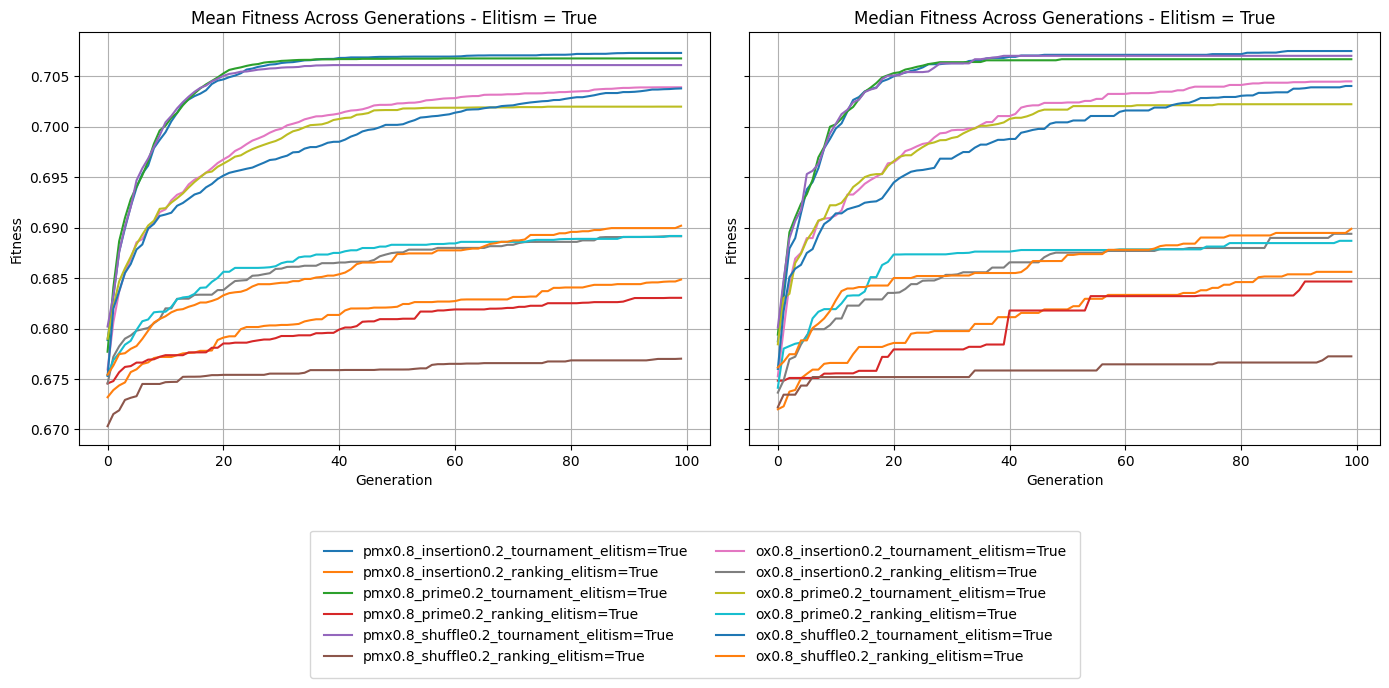

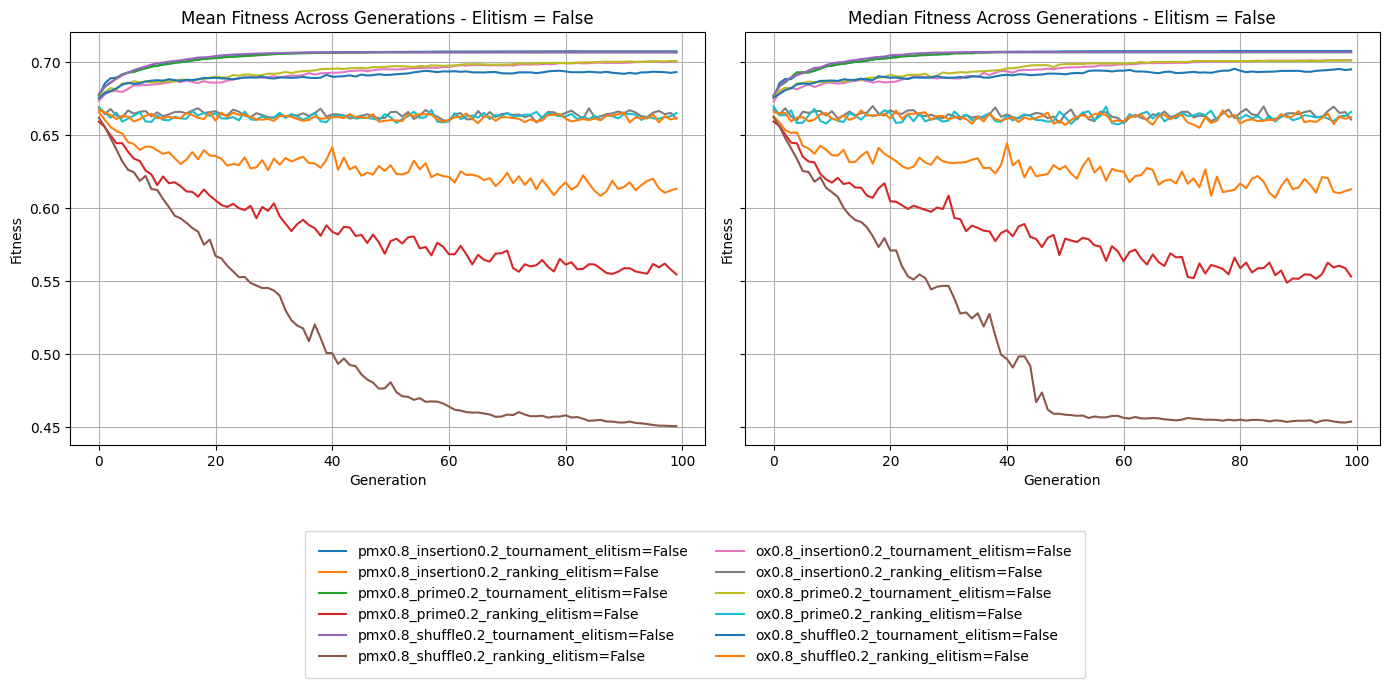

In [42]:
plot_fitness_by_elitism(fitness_dfs)


#### Isolating the Impact of Crossover and Mutation

In [44]:
crossover_names = ["pmx", "ox"]
mutation_names = ["insertion", "prime", "shuffle"]

crossover_fit_dfs = {}
mutation_fit_dfs = {}

for crossover_name in crossover_names:
    dfs_to_concat = []
    for df_name, df in fitness_dfs.items():
        if crossover_name in df_name:
            dfs_to_concat.append(df)
    if dfs_to_concat:  # avoid empty concat
        crossover_fit_dfs[crossover_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)

for mutation_name in mutation_names:
    dfs_to_concat = []
    for df_name, df in fitness_dfs.items():
        if mutation_name in df_name:
            dfs_to_concat.append(df)
    if dfs_to_concat:
        mutation_fit_dfs[mutation_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)


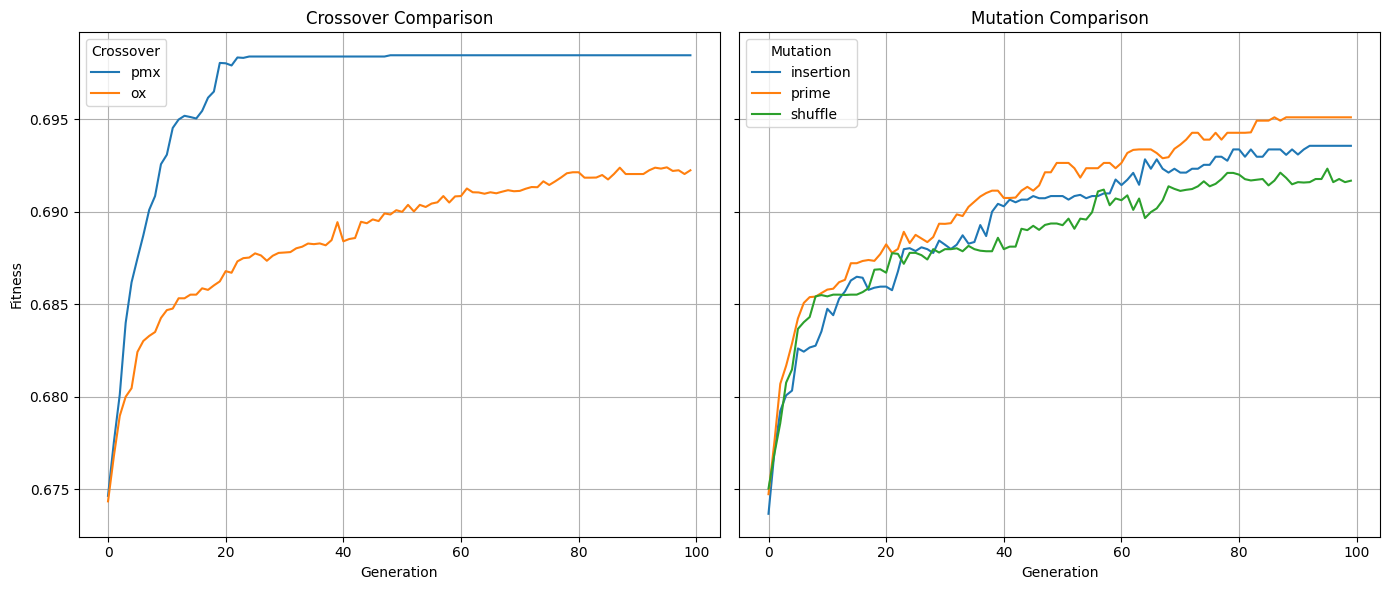

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot crossover results
for name, df in crossover_fit_dfs.items():
    mean_fitness = df.median(axis=0)
    axes[0].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[0].set_title("Crossover Comparison")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("Fitness")
axes[0].legend(title="Crossover")
axes[0].grid(True)

# Plot mutation results
for name, df in mutation_fit_dfs.items():
    mean_fitness = df.median(axis=0)
    axes[1].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[1].set_title("Mutation Comparison")
axes[1].set_xlabel("Generation")
axes[1].legend(title="Mutation")
axes[1].grid(True)

plt.tight_layout()
plt.show()


#### Isolating the Impact of Selection Method

In [46]:
selection_names = ["tournament", "ranking"]

selection_fit_dfs = {}

for selection_name in selection_names:
    dfs_to_concat = []
    for df_name, df in fitness_dfs.items():
        if selection_name in df_name:
            dfs_to_concat.append(df)
    if dfs_to_concat:
        selection_fit_dfs[selection_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)


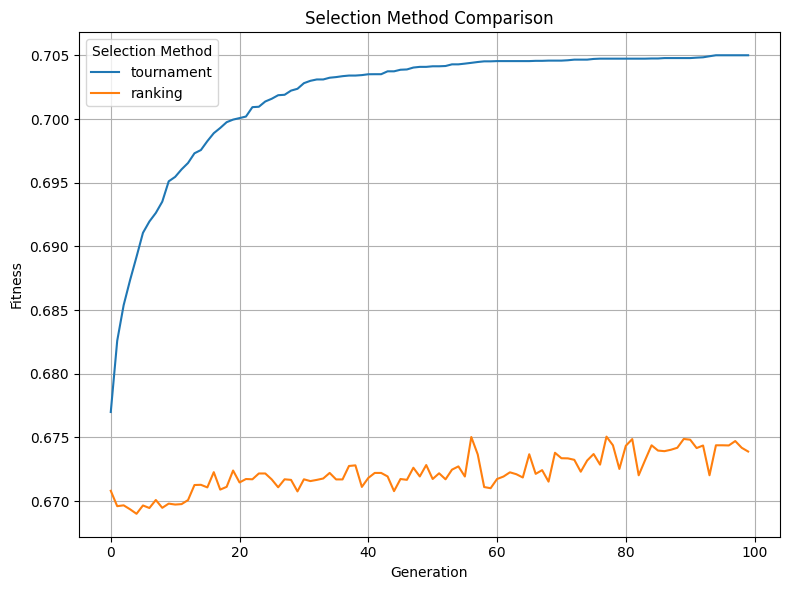

In [47]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot selection results
for name, df in selection_fit_dfs.items():
    median_fitness = df.median(axis=0)
    ax.plot(median_fitness.index, median_fitness.values, label=name)

ax.set_title("Selection Method Comparison")
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")
ax.legend(title="Selection Method")
ax.grid(True)

plt.tight_layout()
plt.show()


### Observations from the Plots

Based on the visual analysis:

- **Elitism** improves overall performance by preserving top individuals.
- **PMX (Partially Matched Crossover)** shows consistently better results than Order Crossover (OX).
- **Prime Slot Mutation** outperforms other mutation strategies.
- **Tournament Selection** leads to stronger convergence and higher fitness.

These settings appear to contribute most effectively to the algorithm's success.


#### Fine-tuning of hyperparameters

Using the best performing setup identified earlier: PMX crossover, prime slot mutation, tournament selection, and elitism enabled.  
We now fix these components and vary the following parameters to identify an optimal configuration:

- Crossover probability (xo_prob)

- Mutation probability (mut_prob)

- Tournament size (k in tournament selection)

The goal is to evaluate how these parameters affect performance and convergence.

In [48]:
POP_SIZE=200 
GENERATIONS=200 

xo_prob = [
    random.uniform(0, 0.2),    
    random.uniform(0.2, 0.4), 
    random.uniform(0.4, 0.6),  
    random.uniform(0.6, 0.8), 
    random.uniform(0.8, 1.0),  
]

mut_prob = [
    random.uniform(0, 0.2),
    random.uniform(0.2, 0.4),
    random.uniform(0.4, 0.6),
    random.uniform(0.6, 0.8),
    random.uniform(0.8, 1.0),
]

# Fixed Parameters that show better results (crossover method, mutation method, selection method and Eletism)
param_options = {
    'xo_prob': xo_prob,
    'mut_prob': mut_prob,
    'crossover_methods': ['pmx'],
    'mutation_methods': ['prime'],
    'selection_methods': [
        (tournament_selection, {'k': 3}),
        (tournament_selection, {'k': 5})
    ],
    'elitism': [True]
}


In [49]:
def sample_random_configs(param_dict, n_samples):
    # Get all options as lists
    keys = list(param_dict.keys())
    all_combinations = list(product(*param_dict.values()))
    
    if n_samples > len(all_combinations):
        print(f"Warning: Requested {n_samples} samples but only {len(all_combinations)} unique combos available.")
        n_samples = len(all_combinations)
        
    sampled_combinations = random.sample(all_combinations, n_samples)
    
    return [
        dict(zip(keys, combo))
        for combo in sampled_combinations
    ]

In [50]:
runs_per_config = 30
num_samples = 20  

sampled_configs = sample_random_configs(param_options, num_samples)

finetune_fitness_results = []

artist_ids = list(artists_df['id'])

for config in sampled_configs:
    config_results = []

    for run_nr in range(runs_per_config):
        initial_population = [
            Solution(
                random.sample(artist_ids, len(artist_ids)),
                artists=artists,
                conflict_matrix=conflict_matrix,
                crossover_method=config['crossover_methods'],
                mutation_method=config['mutation_methods']
            )
            for _ in range(POP_SIZE)
        ]

        best_solution, _ = genetic_algorithm(
            initial_population=initial_population,
            max_gen=GENERATIONS,
            selection_algorithm=config['selection_methods'][0],
            maximization=True,
            xo_prob=config['xo_prob'],
            mut_prob=config['mut_prob'],
            elitism=True,
            verbose=False,
            track_history=False,
            **config['selection_methods'][1]
        )

        config_results.append(best_solution.fitness())

    config_label = (
        f"xo_prob={round(config['xo_prob'], 2)}_mut_prob={round(config['mut_prob'], 2)}_"
        f"xo={config['crossover_methods']}_mut={config['mutation_methods']}_"
        f"sel={config['selection_methods'][0].__name__}"
    )

    finetune_fitness_results.append({
        'Configuration': config_label,
        'Fitness_Values': config_results
    })


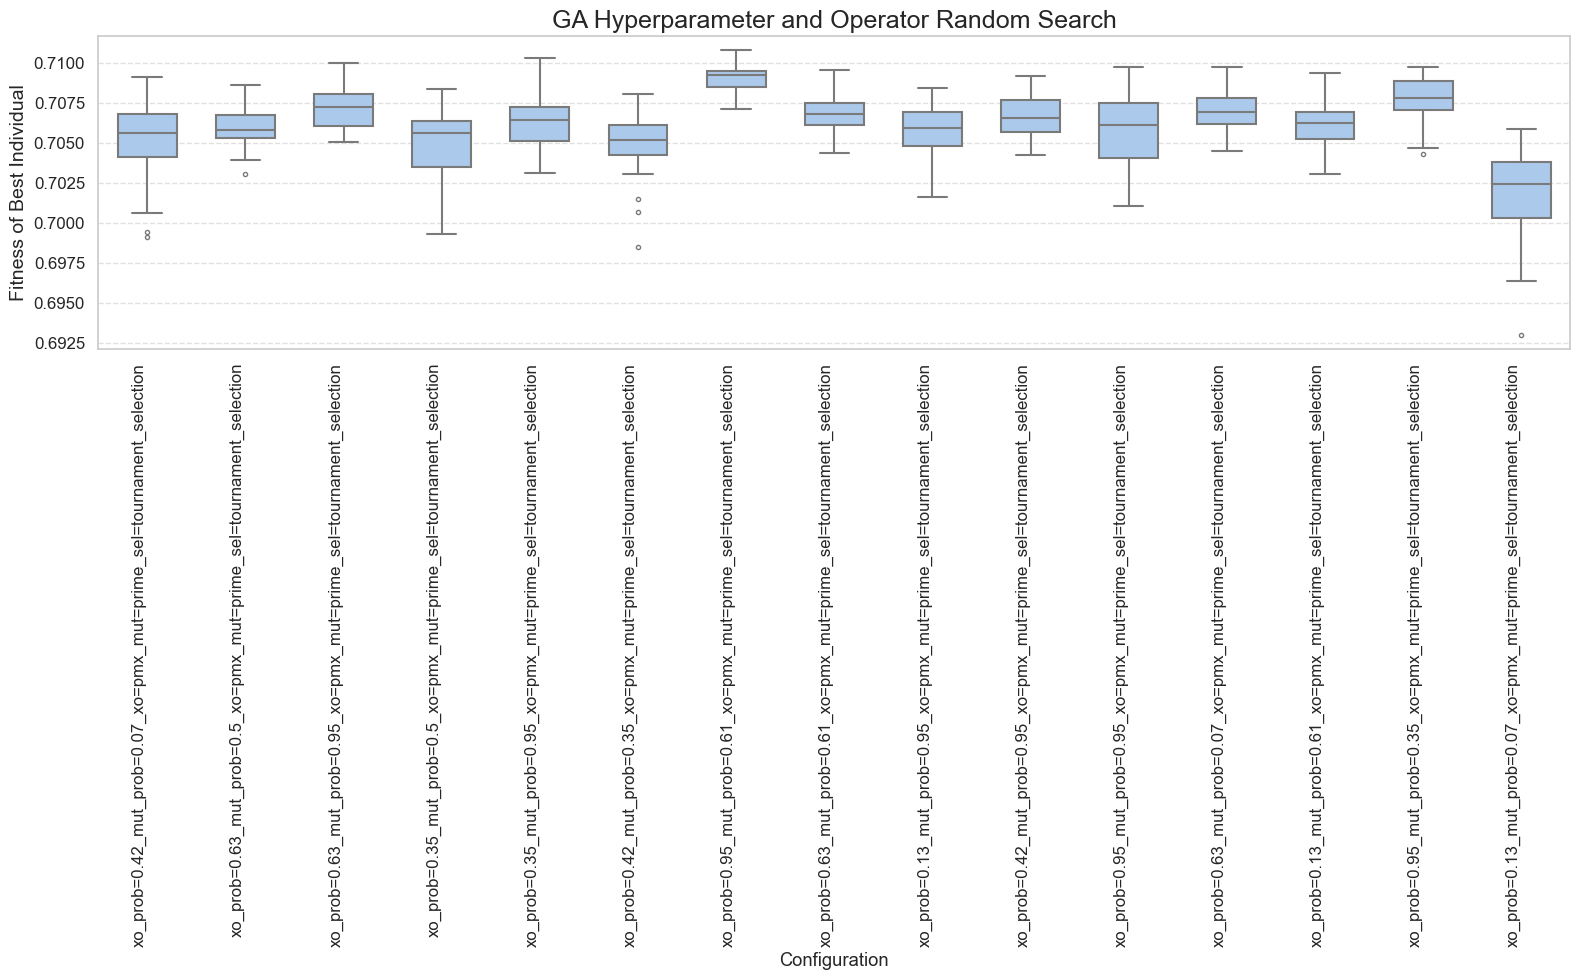

In [53]:
data = []
for entry in finetune_fitness_results:
    for value in entry['Fitness_Values']:
        data.append({
            'Fitness': value,
            'Configuration': entry['Configuration']
        })

df_long = pd.DataFrame(data)

sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.1)
plt.figure(figsize=(16, 10))
ax = sns.boxplot(x='Configuration', y='Fitness', data=df_long, width=0.6, linewidth=1.5, fliersize=3)

plt.title('GA Hyperparameter and Operator Random Search', fontsize=18)
plt.ylabel('Fitness of Best Individual', fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [54]:
# Convert long-format data to a DataFrame
df_long = pd.DataFrame([
    {'Configuration': entry['Configuration'], 'Fitness': value}
    for entry in finetune_fitness_results
    for value in entry['Fitness_Values']
])

# Export to CSV
df_long.to_csv("ga_fitness_results.csv", index=False)
print("Fitness results exported to 'ga_fitness_results.csv'")

Fitness results exported to 'ga_fitness_results.csv'


In [55]:
# Get best configuration by average fitness
best_result = max(
    finetune_fitness_results,
    key=lambda x: sum(x['Fitness_Values']) / len(x['Fitness_Values'])
)

# Stats
avg_fitness = sum(best_result['Fitness_Values']) / len(best_result['Fitness_Values'])
max_fitness = max(best_result['Fitness_Values'])
min_fitness = min(best_result['Fitness_Values'])

print("\nBest Configuration Found:")
print(f"Configuration: {best_result['Configuration']}")
print(f"Average Fitness: {avg_fitness:.2f}")
print(f"Max Fitness: {max_fitness:.2f}")
print(f"Min Fitness: {min_fitness:.2f}")



Best Configuration Found:
Configuration: xo_prob=0.95_mut_prob=0.61_xo=pmx_mut=prime_sel=tournament_selection
Average Fitness: 0.71
Max Fitness: 0.71
Min Fitness: 0.71


In [58]:
# Number of stages and slots
num_stages = 5
num_slots = 7

# Get the best solution (list of indices)
best_artist_solution = [artists[i] for i in best_solution.representation]

# Create a 2D list (5 stages x 7 slots) to represent the schedule
schedule = [[None for _ in range(num_slots)] for _ in range(num_stages)]

# Fill the schedule with the artists based on the best solution
for stage in range(num_stages):
    for slot in range(num_slots):
        index = stage * num_slots + slot
        schedule[stage][slot] = best_artist_solution[index]

# Display the schedule
for stage in range(num_stages):
    print(f"Stage {stage + 1}:")
    for slot in range(num_slots):
        artist = schedule[stage][slot]
        print(f"  Slot {slot + 1}: {artist.name}, Popularity: {artist.popularity}, Genre: {artist.genre}")
    print()


Stage 1:
  Slot 1: Static Mirage, Popularity: 94, Genre: Rock
  Slot 2: The Silver Owls, Popularity: 85, Genre: Classical
  Slot 3: Parallel Dimension, Popularity: 58, Genre: Electronic
  Slot 4: Shadow Cadence, Popularity: 66, Genre: Jazz
  Slot 5: Phantom Groove, Popularity: 47, Genre: Hip-Hop
  Slot 6: Nightfall Sonata, Popularity: 84, Genre: Classical
  Slot 7: Cloud Nine Collective, Popularity: 97, Genre: Pop

Stage 2:
  Slot 1: Turbo Vortex, Popularity: 53, Genre: Rock
  Slot 2: The Wandering Notes, Popularity: 84, Genre: Jazz
  Slot 3: Hypnotic Echoes, Popularity: 77, Genre: Rock
  Slot 4: The Jazz Nomads, Popularity: 64, Genre: Jazz
  Slot 5: Midnight Echo, Popularity: 75, Genre: Rock
  Slot 6: Electric Serpents, Popularity: 99, Genre: Electronic
  Slot 7: Echo Chamber, Popularity: 98, Genre: Electronic

Stage 3:
  Slot 1: The Sonic Drifters, Popularity: 88, Genre: Rock
  Slot 2: The Bassline Architects, Popularity: 61, Genre: Hip-Hop
  Slot 3: Velvet Underground, Popularity: 7

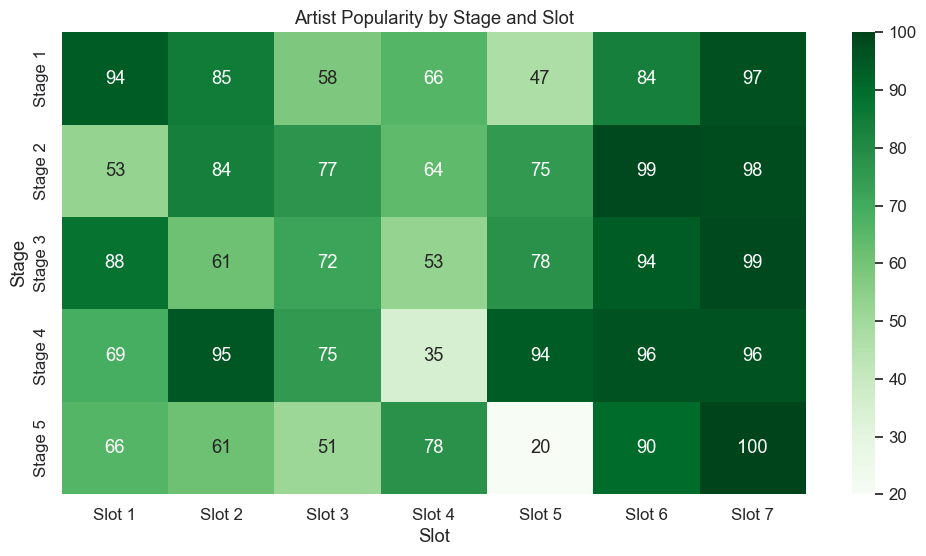

In [60]:
# Heatmap of popularity
popularity_matrix = [[schedule[stage][slot].popularity for slot in range(num_slots)] for stage in range(num_stages)]

plt.figure(figsize=(12, 6))
sns.heatmap(popularity_matrix, annot=True, fmt=".0f", cmap="Greens", 
            xticklabels=[f"Slot {j+1}" for j in range(num_slots)],
            yticklabels=[f"Stage {i+1}" for i in range(num_stages)])
plt.title("Artist Popularity by Stage and Slot")
plt.xlabel("Slot")
plt.ylabel("Stage")
plt.show()

Just for experimenting: Mutation=insertion

In [61]:
POP_SIZE=200 
GENERATIONS=200 

xo_prob = [
    random.uniform(0, 0.2),    
    random.uniform(0.2, 0.4), 
    random.uniform(0.4, 0.6),  
    random.uniform(0.6, 0.8), 
    random.uniform(0.8, 1.0),  
]

mut_prob = [
    random.uniform(0, 0.2),
    random.uniform(0.2, 0.4),
    random.uniform(0.4, 0.6),
    random.uniform(0.6, 0.8),
    random.uniform(0.8, 1.0),
]

# Fixed Parameters that show better results (crossover method, mutation method, selection method and Eletism)
param_options_2 = {
    'xo_prob': xo_prob,
    'mut_prob': mut_prob,
    'crossover_methods': ['pmx'],
    'mutation_methods': ['insertion'],
    'selection_methods': [
        (tournament_selection, {'k': 3}),
        (tournament_selection, {'k': 5})
    ],
    'elitism': [True]
}

In [62]:
runs_per_config = 30
num_samples = 20  

sampled_configs = sample_random_configs(param_options_2, num_samples)

finetune_fitness_results = []

artist_ids = list(artists_df['id'])

for config in sampled_configs:
    config_results = []

    for run_nr in range(runs_per_config):
        initial_population = [
            Solution(
                random.sample(artist_ids, len(artist_ids)),
                artists=artists,
                conflict_matrix=conflict_matrix,
                crossover_method=config['crossover_methods'],
                mutation_method=config['mutation_methods']
            )
            for _ in range(POP_SIZE)
        ]

        best_solution, _ = genetic_algorithm(
            initial_population=initial_population,
            max_gen=GENERATIONS,
            selection_algorithm=config['selection_methods'][0],
            maximization=True,
            xo_prob=config['xo_prob'],
            mut_prob=config['mut_prob'],
            elitism=True,
            verbose=False,
            track_history=False,
            **config['selection_methods'][1]
        )

        config_results.append(best_solution.fitness())

    config_label = (
        f"xo_prob={round(config['xo_prob'], 2)}_mut_prob={round(config['mut_prob'], 2)}_"
        f"xo={config['crossover_methods']}_mut={config['mutation_methods']}_"
        f"sel={config['selection_methods'][0].__name__}"
    )

    finetune_fitness_results.append({
        'Configuration': config_label,
        'Fitness_Values': config_results
    })

KeyboardInterrupt: 

In [ ]:
data = []
for entry in finetune_fitness_results:
    for value in entry['Fitness_Values']:
        data.append({
            'Fitness': value,
            'Configuration': entry['Configuration']
        })

df_long = pd.DataFrame(data)

sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.1)
plt.figure(figsize=(16, 10))
ax = sns.boxplot(x='Configuration', y='Fitness', data=df_long, width=0.6, linewidth=1.5, fliersize=3)

plt.title('GA Hyperparameter and Operator Random Search', fontsize=18)
plt.ylabel('Fitness of Best Individual', fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Get best configuration by average fitness
best_result = max(
    finetune_fitness_results,
    key=lambda x: sum(x['Fitness_Values']) / len(x['Fitness_Values'])
)

# Stats
avg_fitness = sum(best_result['Fitness_Values']) / len(best_result['Fitness_Values'])
max_fitness = max(best_result['Fitness_Values'])
min_fitness = min(best_result['Fitness_Values'])

print("\nBest Configuration Found:")
print(f"Configuration: {best_result['Configuration']}")
print(f"Average Fitness: {avg_fitness:.2f}")
print(f"Max Fitness: {max_fitness:.2f}")
print(f"Min Fitness: {min_fitness:.2f}")